# DTSA 5509 Final Project
#### Mikhail (Mike) Vasilyev
#### April 2024


# Background and Introduction
Hello everyone!
This is my final project for DTSA-5509! Thank you for taking the time to view and grade this. I hope this provides to be a valuable experience!

In this project I wanted to expand upon the computer vision that we briefly touched on in week 4 when classifying the MNIST dataset. I enoyed the computer vision challenge and am hoping to apply similar methods to a different problem.

For this project, my goal is to classify metallurgical defects in microscope images of processed steel. My undergraduate background is in materials engineering, and my full-time job includes a lot of materials engineering and recognition of defects in microscopy. 

The six possible defects in steel we will be looking at are:

Crazing -
Inclusion -
Patches - 
Pitting-
Rolling - 
Scratches

Correct identification of these defects is a necessary task in both industry and academia. In process engineering and failure analysis, it is very important to recognize the nature of the defect in order to provide solutions or prevention. 

My goal is to correctly identify these defects in order to aid in failure analysis and - more broadly - to get better experience with computer vision.

I took the dataset from Kaggle. The link to the dataset is https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data. You will have to download this dataset in order to run this code on your personal device.

I will be using three different ML models that we learned about in this course to classify the images:

1) KNN Classifier

2) AdaBoost Classifier

3) Random Forest Classifier

I will use multiple methods to preprocess the data in order to make the model more accurate:

1) Scaling

2) Dimensionality Reduction

3) HOG and LBP


### Results
For anyone just skimming through, I will share the results here:
The random forest algorithm using dimensionality reduction, scaling, HOG and LPB was able to get a test accuracy of ~96%. This is pretty good for image data. KNN was the least effective method - only acheiving an accuracy of around 60%. Similarly, AdaBoost was able to reach around 75% by only using scaling and dimensionality reduction.

Importing the Necessary Libraries Below. All of these libraries are installed by default in the standard distribution of Anaconda. 


In [6]:
import os
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from math import exp
import numpy as np
import pandas as pd
import sklearn

The code below imports the dataset and puts the images into a readable np array format that can be used for machine learning. If you are doing this on your personal computer, replace my filepath in the code with your filepath of where you are holding the test and train folders with the images. 

In [7]:
# Define a function to load and process images from a folder
def load_train_images_from_folder(folder):
    folder = os.path.join(r'C:\Users\hailm\OneDrive\Documents\CU Boulder\DTSA5509\train',folder)
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".jpg") or img_path.endswith(".bmp"):
            img = Image.open(img_path).convert("L")
            img_array = np.array(img).flatten()
            images.append(img_array)
            label = os.path.basename(folder)
            labels.append(label)
    return images, labels
    
def load_test_images_from_folder(folder):
    folder = os.path.join(r'C:\Users\hailm\OneDrive\Documents\CU Boulder\DTSA5509\test',folder)
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".jpg") or img_path.endswith(".bmp"):
            img = Image.open(img_path).convert("L")
            img_array = np.array(img).flatten()
            images.append(img_array)
            label = os.path.basename(folder)
            labels.append(label)
    return images, labels
    
def load_train_data_from_folders(folders):
    all_images = []
    all_labels = []
    for folder in folders:
        images, labels = load_train_images_from_folder(folder)
        all_images.extend(images)
        all_labels.extend(labels)
    return np.array(all_images), np.array(all_labels)

def load_test_data_from_folders(folders):
    all_images = []
    all_labels = []
    for folder in folders:
        images, labels = load_test_images_from_folder(folder)
        all_images.extend(images)
        all_labels.extend(labels)
    return np.array(all_images), np.array(all_labels)


folders = ["crazing", "inclusion", "patches", "pitted", "rolled", "scratches"]


X_train, y_train = load_train_data_from_folders(folders)
X_test, y_test = load_test_data_from_folders(folders)

print("Shape of X_train:", X_train.shape)  # This prints the number of images and the image size (num_images, image_size). ~1600 training images
print("Shape of X_test:", X_test.shape)  # This prints the number of images and the image size (num_images, image_size) ~72 test images

Shape of X_train: (1656, 40000)
Shape of X_test: (72, 40000)


The code below allows you to view any image from the datasets

In [8]:
def view_defect_image(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(200,200), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

inclusion


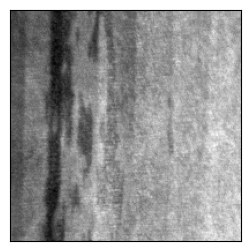

In [5]:
#command to see an inclusion defect
view_defect_image(X_test[16])
print(y_test[16])

crazing


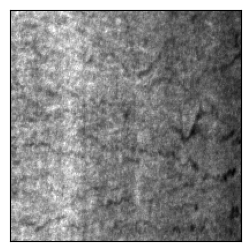

In [6]:
#command to see crazing defect
view_defect_image(X_test[1])
print(y_test[1])

patches


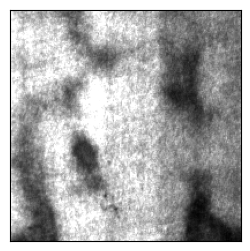

In [7]:
#command to see patches defect
view_defect_image(X_test[30])
print(y_test[30])

pitted


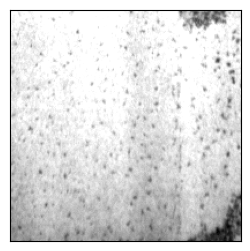

In [8]:
#command to see pitting defect
view_defect_image(X_test[40])
print(y_test[40])

rolled


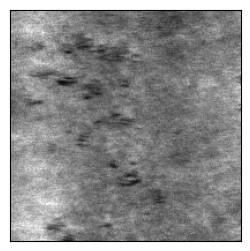

In [9]:
#command to see a rolled defect
view_defect_image(X_test[50])
print(y_test[50])

scratches


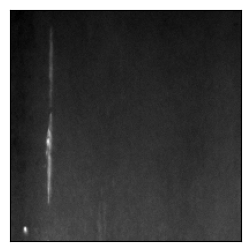

In [10]:
#command to see a scratch defect
view_defect_image(X_test[60])
print(y_test[60])

###  K-nearest neighbors (KNN)
Below is the code for the first algorithm I will be using: KNN. 

I preprocessed the images first by scaling them. Scaling features is good practice for using KNN to classify images because of how it calculates distance. The KNN algorithm calculates distances between data points to determine their similarity. If features are not scaled, those with larger values might dominate, leading to errnious results. 

As the images are currently represented, the values range from 0-255. I scaled the range down to 0-1 to ensure that each feature contributes equally and that no features dominate too much. This improves the classification accuracy of KNN.

If you are interested in seeing the performance difference, you can train and test the model on X_train/X_test instead of X_train_scaled/X_test_scaled

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier


# Feature Scaling. This converts the range of brighness values from 0-255 to 0-1. This helps with KNN algorithm to make it more accurate. 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


k = 3  # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
#knn_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train_scaled, y_train)

accuracy = knn_classifier.score(X_test_scaled, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.3888888888888889


We can do a grid search and find the best k-value for our algorithm. Below, I will find the optimal k-value between 1 and 11.

In [15]:
from sklearn.model_selection import GridSearchCV
params_to_try = {"n_neighbors" : [i for i in range(1, 11)]}
KNN = KNeighborsClassifier()
grid = GridSearchCV(estimator = KNN, param_grid = params_to_try)

grid.fit(X_train_scaled, y_train)

print(grid.best_params_ , grid.best_score_)

{'n_neighbors': 1} 0.38644851308557493


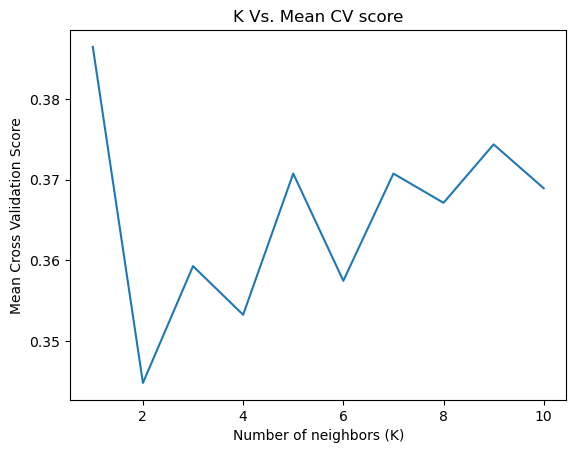

In [17]:
KNN_results_dic = grid.cv_results_
KNN_results = pd.DataFrame(KNN_results_dic)
neighbors = list(KNN_results["param_n_neighbors"])
mean_score = list(KNN_results["mean_test_score"])

plt.plot(neighbors, mean_score)
plt.title("K Vs. Mean CV score")
plt.xlabel("Number of neighbors (K)")
plt.ylabel("Mean Cross Validation Score")
plt.show()

Unfortunately, the KNN algorithm was not very accurate by only scaling the images before fitting the model. The next step would be to use dimensionality reduction on the image data. KNN suffers from the curse of dimensionality - so using Principal Component Analysis (PCA) to reduce it might help.

The images I am using are highly-dimensional. This can generally lead to overfitting or inaccurate results. PCA reduces the dimensionality by retaining only the most informative and relevant features of the image.

In [18]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=100) 

pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("pca", pca),
    ("knn", knn_classifier)
])

pipeline.fit(X_train_scaled, y_train)

accuracy = pipeline.score(X_test_scaled, y_test)
print("Accuracy on test data:", accuracy)


Accuracy on test data: 0.5694444444444444


### AdaBoost Classifier
The next algorthm we will use is AdaBoost. I will preprocess the data with scaling and dimensionality reduction.
As can be seen below, the AdaBoost was much more effective than KNN for classifying my image dataset. Still, this accuracy is insufficient. But generally, I can say that AdaBoost is more effective than KNN for image classification of this specific dataset. 

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [22]:


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=40)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


n_trees = 115 #115
base_classifier = DecisionTreeClassifier(max_depth=7) #7
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=n_trees, learning_rate = 1) #1
adaboost_classifier.fit(X_train_pca, y_train)

accuracy = adaboost_classifier.score(X_test_pca, y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8194444444444444


### Random Forest Classifier
The next algorthm we will use is the random forest. First, I will only preprocess the data with scaling and dimensionality reduction. Later I will use more advanced preprocessing tecniques.
As can be seen below, the Random Forest and AdaBoost has very similar results using only dimensionality reduction and scaling as their preprocessing tecniques.

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [24]:
n_estimators = 300  # 100
max_depth = None 

random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
random_forest_classifier.fit(X_train_pca, y_train)

accuracy = random_forest_classifier.score(X_test_pca, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8333333333333334


Below is the code to find the optimal combinations of n_estimators, max_depth, min_samples_per_split, and min_samples_per_leaf.
Better results can be seen with more depth and splits. 

In [135]:
param_grid = {
    'n_estimators': [300],  
    'max_depth': [None],  
    #'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4] 
}

rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_pca, y_train)

print("Best parameters:", grid_search.best_params_)

print("Best accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_pca, y_test)
print("Test accuracy:", test_accuracy)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
Best accuracy: 0.7807847705019475
Test accuracy: 0.8194444444444444


### HOG and LBP
Below I implemented HOG and LBP to preprocess the images. This yielded a 96% accuracy with random forest classifier. 

LBP stands for Local Binary Pattern. It is designed for greyscale images by effectively and efficiently capturing textures and texture differences in an image. Out defects have different textures, so the ability of LBP to recognize and detect textures works very well for our application. LBP works by comparing the intensity of pixels with their neighboring pixels. The comparisons/patters are converted into decimal values - which represent the underlying textures and differences between textures. 

HOG stands for histogram of oriented gradients. Unlike LBP which gives texture detection, HOG gives edge detection. This is just as useful for us because it can attempt to detect edges of each defect. HOG works by dividing the image into smaller cells and computing histograms of gradient orientations within each cell. HOG then returns the distribution of intensity gradients, which provide information about the edges. 

In [43]:

# Preprocessing function
import numpy as np
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Preprocessing function
def preprocess_dataset(X, y):
    hog_features = []
    lbp_features = []

    for image in X:
        # Reshape image to 2D (assuming it's originally a 1D array)
        image_2d = image.reshape((200, 200))
        
        # Convert image to grayscale
        image_gray = image_2d / 255.0  # Assuming pixel values are in the range [0, 255]
        
        # Extract HOG features
        hog_feat = hog(image_gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys')
        hog_features.append(hog_feat)
        
        # Extract LBP features
        lbp_feat = local_binary_pattern(image_gray, P=8, R=3, method='uniform')
        lbp_hist, _ = np.histogram(lbp_feat.ravel(), bins=np.arange(0, 10), range=(0, 9))
        lbp_features.append(lbp_hist)
    
    #return np.hstack((hog_features, lbp_features)), y
    combined_features = np.hstack((hog_features, lbp_features))
    
    # Performs PCA
    pca = PCA(n_components=40)  # Adjust the number of components as needed
    combined_features_pca = pca.fit_transform(combined_features)
    
    # Scales
    scaler = StandardScaler()
    combined_features_scaled = scaler.fit_transform(combined_features_pca)
    
    return combined_features_scaled, y


# Preprocess the dataset
X_processed, y_processed = preprocess_dataset(X_train, y_train)


C:\Users\hailm\anaconda3\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [45]:


X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=300, max_depth=None)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9728915662650602


### Results/Conclusion
I was able to acheive a classification accuracy around 97% by using a random forest and applying complex preproccessing tecniques. The preproccessing made the biggest difference. Without HOG and LBP, the accuracy of my random forest and my gradient boosted alogrithm were around 75-80% respectively. But, by applying HOG and LCD, the accuracy of the random forest went up to 97%. This is a significant difference. Similarly - my accuracy for KNN without any preprocessing was an abyssmal 38%. After applying basic preprocessing tecniques such as scaling and dimensionality reduction, the KNN accuracy went up to 55%. I learned that the preprocessing matters just as much - if not more - than the algorithm being chosen. 